<a href="https://colab.research.google.com/github/nielsrolf/GAN-TUBerlin/blob/master/colab_gan_that_imports_from_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone or update the repo, then import it

In [1]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)
PROJ = "My Drive/gan_tu" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)

!mkdir "{PROJECT_PATH}"
!git clone https://github.com/nielsrolf/GAN-TUBerlin.git "{PROJECT_PATH}"
!cd "{PROJECT_PATH}" && git pull

regular_training = False
unconnected_support_prior = False
train_d_more_often = True

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/gan_tu’: File exists
fatal: destination path '/content/drive/My Drive/gan_tu' already exists and is not an empty directory.
remote: Enumerating objects: 5, done.
ls
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/nielsrolf/GAN-TUBerlin
   9b7b

In [0]:
from importlib.machinery import SourceFileLoader
gan = SourceFileLoader('gan', join(PROJECT_PATH, 'gan.py')).load_module()
callbacks = SourceFileLoader('callbacks', join(PROJECT_PATH, 'callbacks.py')).load_module()


# Get the data

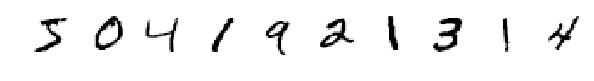

(60000, 10)

In [14]:
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
import sys
import numpy as np

# Load the dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.

X_train = np.reshape(X_train, [-1, 28, 28, 1])
X_test = np.reshape(X_test, [-1, 28, 28, 1])

X_train.shape
callbacks.show(X_train[:10])

# transform it to one hot encoding
Y_train = np.eye(10)[Y_train]
Y_test = np.eye(10)[Y_test]

# Regular Training


0 [D loss: 0.765461, acc.: 46.09%] [G loss: 0.910440]

1 [D loss: 0.749428, acc.: 46.48%] [G loss: 0.863517]

2 [D loss: 0.699151, acc.: 51.17%] [G loss: 0.905651]

3 [D loss: 0.725512, acc.: 53.52%] [G loss: 0.888136]

4 [D loss: 0.702407, acc.: 53.12%] [G loss: 0.835929]

5 [D loss: 0.662111, acc.: 58.98%] [G loss: 0.905099]

6 [D loss: 0.684763, acc.: 58.20%] [G loss: 0.849231]

7 [D loss: 0.675482, acc.: 60.16%] [G loss: 0.884973]

8 [D loss: 0.704503, acc.: 53.91%] [G loss: 0.831993]

9 [D loss: 0.688653, acc.: 57.42%] [G loss: 0.837480]


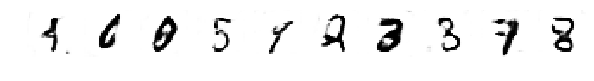

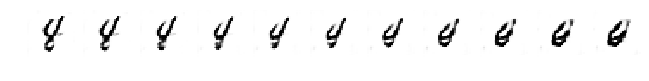

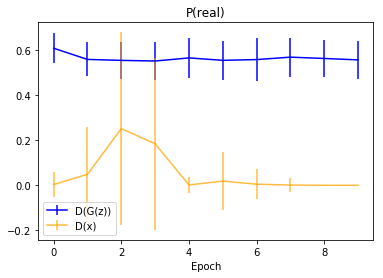

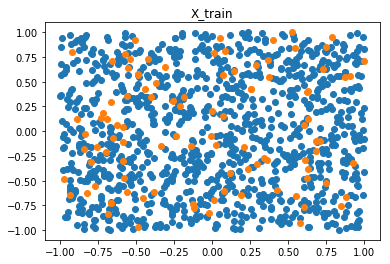

Reconstruction X_train


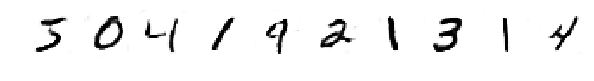

Original X_train


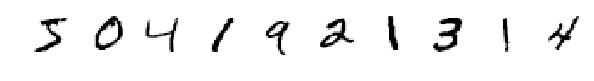

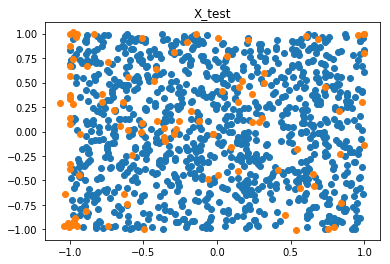

Reconstruction X_test


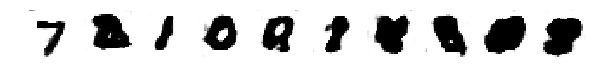

Original X_test


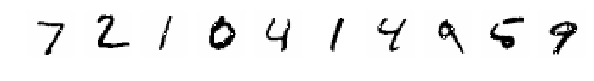


10 [D loss: 0.701783, acc.: 57.03%] [G loss: 0.861171]

11 [D loss: 0.684661, acc.: 53.52%] [G loss: 0.845943]

12 [D loss: 0.673809, acc.: 57.03%] [G loss: 0.808301]

13 [D loss: 0.690932, acc.: 54.69%] [G loss: 0.811150]

14 [D loss: 0.680556, acc.: 55.86%] [G loss: 0.832714]

15 [D loss: 0.692054, acc.: 56.25%] [G loss: 0.850400]

16 [D loss: 0.678908, acc.: 57.03%] [G loss: 0.852861]

17 [D loss: 0.705370, acc.: 50.78%] [G loss: 0.831649]

18 [D loss: 0.687576, acc.: 55.86%] [G loss: 0.867893]

19 [D loss: 0.680797, acc.: 55.08%] [G loss: 0.887063]


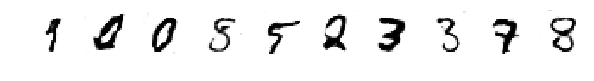

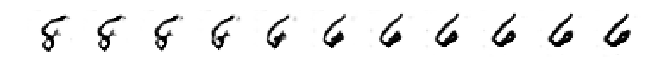

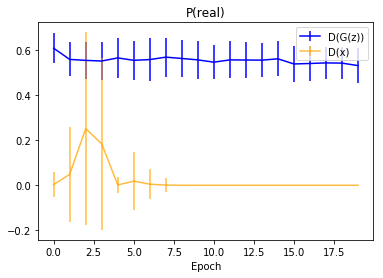

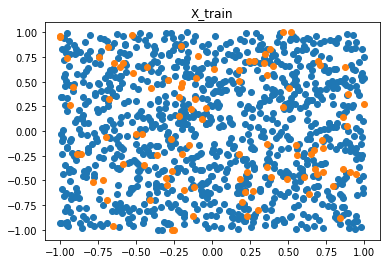

Reconstruction X_train


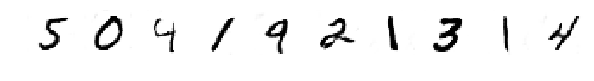

Original X_train


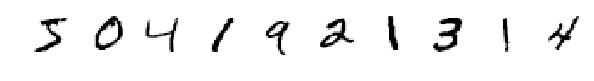

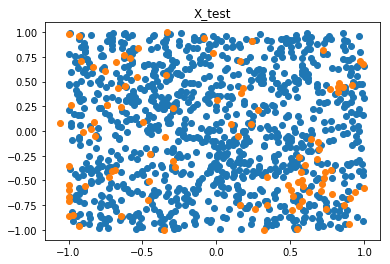

Reconstruction X_test


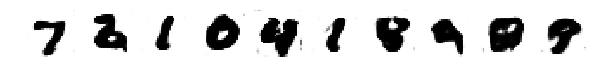

Original X_test


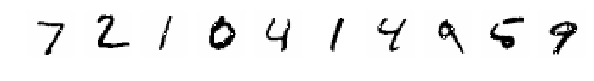


20 [D loss: 0.693842, acc.: 55.86%] [G loss: 0.809814]

21 [D loss: 0.671964, acc.: 59.77%] [G loss: 0.856965]

22 [D loss: 0.627724, acc.: 68.75%] [G loss: 0.830937]

23 [D loss: 0.671278, acc.: 57.03%] [G loss: 0.861476]

24 [D loss: 0.700010, acc.: 54.69%] [G loss: 0.814979]

25 [D loss: 0.683827, acc.: 54.69%] [G loss: 0.828719]

26 [D loss: 0.671533, acc.: 60.55%] [G loss: 0.845513]

27 [D loss: 0.705758, acc.: 53.12%] [G loss: 0.839697]

28 [D loss: 0.701534, acc.: 51.17%] [G loss: 0.779691]

29 [D loss: 0.697426, acc.: 54.69%] [G loss: 0.831252]


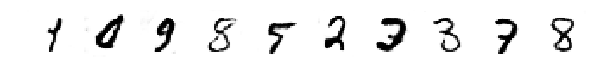

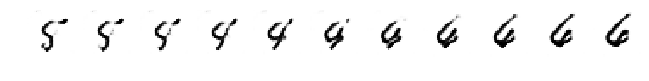

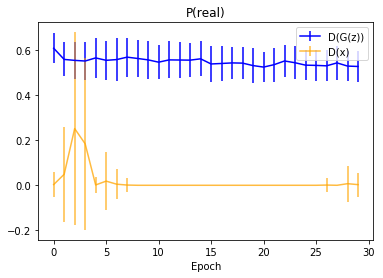

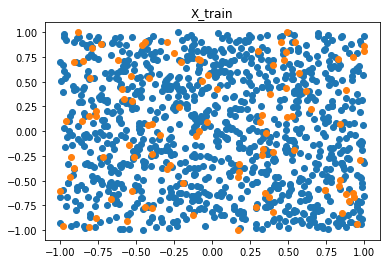

Reconstruction X_train


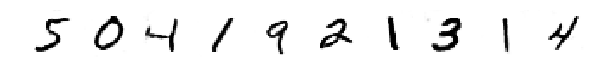

Original X_train


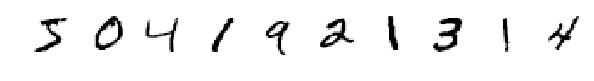

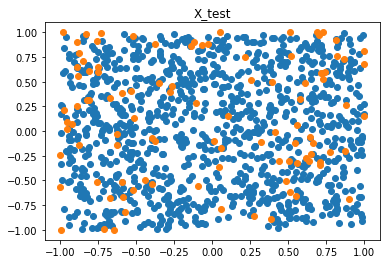

Reconstruction X_test


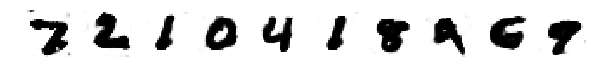

Original X_test


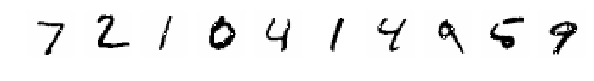


30 [D loss: 0.662265, acc.: 59.38%] [G loss: 0.897051]

31 [D loss: 0.655182, acc.: 59.77%] [G loss: 0.877915]

32 [D loss: 0.693146, acc.: 53.91%] [G loss: 0.870046]

33 [D loss: 0.704417, acc.: 51.56%] [G loss: 0.854922]

34 [D loss: 0.671224, acc.: 55.47%] [G loss: 0.880974]

35 [D loss: 0.677707, acc.: 58.59%] [G loss: 0.823231]

36 [D loss: 0.697038, acc.: 50.39%] [G loss: 0.817617]

37 [D loss: 0.708951, acc.: 54.69%] [G loss: 0.827356]

38 [D loss: 0.663520, acc.: 58.20%] [G loss: 0.820277]

39 [D loss: 0.688562, acc.: 54.69%] [G loss: 0.881575]


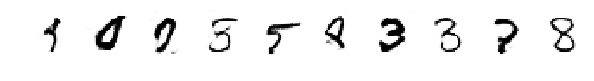

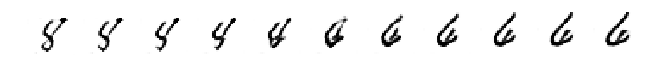

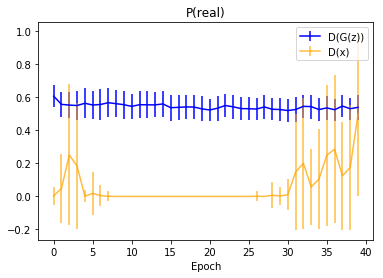

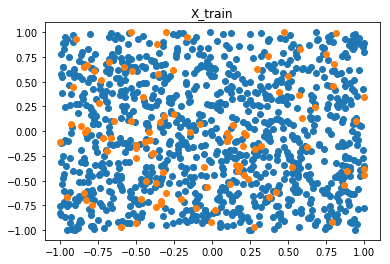

Reconstruction X_train


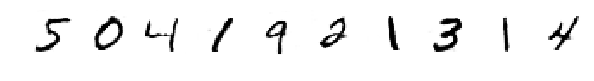

Original X_train


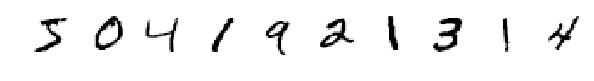

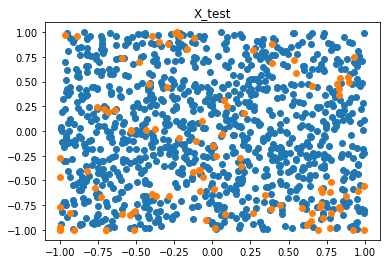

Reconstruction X_test


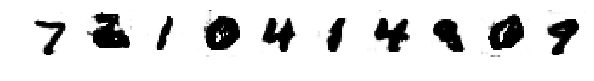

Original X_test


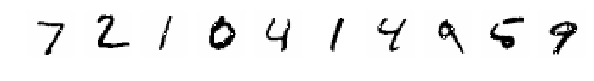


40 [D loss: 0.709141, acc.: 50.78%] [G loss: 0.882023]

41 [D loss: 0.659292, acc.: 63.28%] [G loss: 0.851366]

42 [D loss: 0.686360, acc.: 53.12%] [G loss: 0.866201]

43 [D loss: 0.623737, acc.: 69.53%] [G loss: 0.852195]

44 [D loss: 0.670473, acc.: 61.33%] [G loss: 0.890278]

45 [D loss: 0.668489, acc.: 58.20%] [G loss: 0.828416]

46 [D loss: 0.727540, acc.: 47.27%] [G loss: 0.847590]

47 [D loss: 0.730061, acc.: 50.39%] [G loss: 0.800044]

48 [D loss: 0.697474, acc.: 53.91%] [G loss: 0.835098]

49 [D loss: 0.646131, acc.: 63.28%] [G loss: 0.940679]


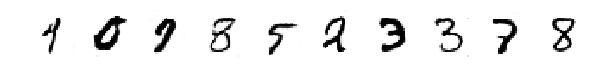

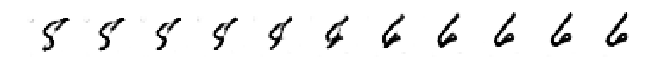

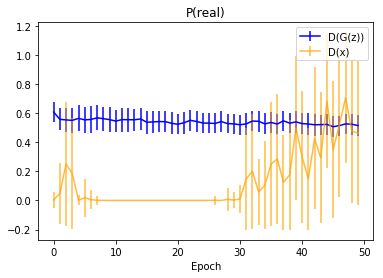

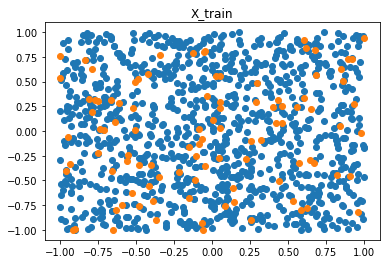

Reconstruction X_train


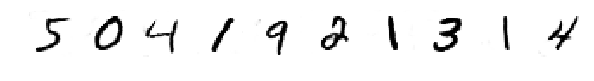

Original X_train


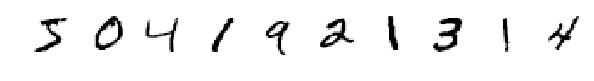

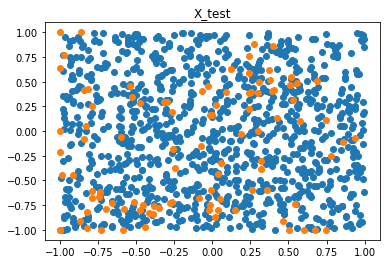

Reconstruction X_test


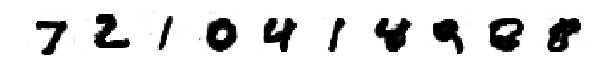

Original X_test


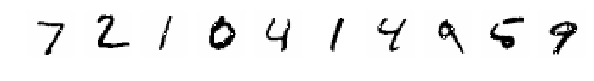


50 [D loss: 0.639141, acc.: 64.84%] [G loss: 0.842384]

51 [D loss: 0.688527, acc.: 53.52%] [G loss: 0.830474]

52 [D loss: 0.675172, acc.: 58.20%] [G loss: 0.870511]

53 [D loss: 0.693542, acc.: 53.12%] [G loss: 0.756565]

54 [D loss: 0.658302, acc.: 62.89%] [G loss: 0.861988]

55 [D loss: 0.647120, acc.: 63.67%] [G loss: 0.840158]

56 [D loss: 0.669829, acc.: 58.20%] [G loss: 0.794100]

57 [D loss: 0.578705, acc.: 70.31%] [G loss: 0.975589]

58 [D loss: 0.657629, acc.: 57.42%] [G loss: 0.948870]

59 [D loss: 0.636395, acc.: 66.02%] [G loss: 0.941055]


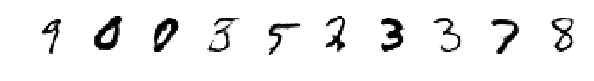

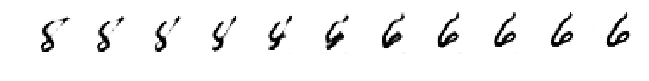

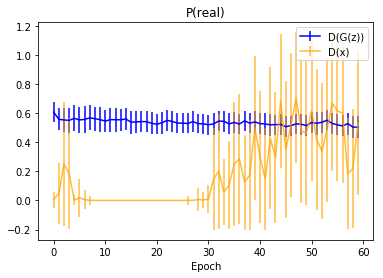

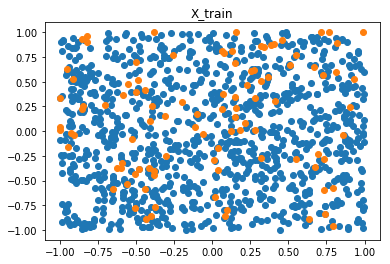

Reconstruction X_train


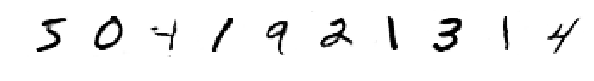

Original X_train


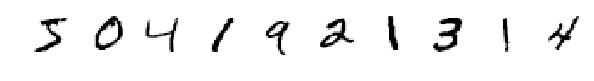

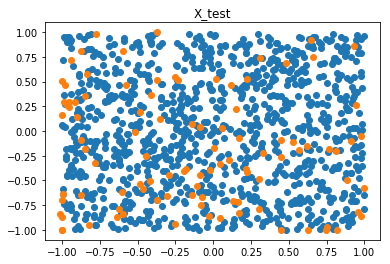

Reconstruction X_test


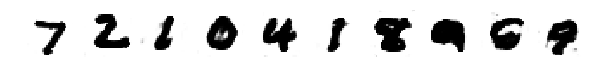

Original X_test


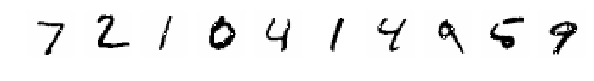


60 [D loss: 0.640712, acc.: 59.38%] [G loss: 0.969402]

61 [D loss: 0.601346, acc.: 66.02%] [G loss: 0.917965]

62 [D loss: 0.672579, acc.: 60.55%] [G loss: 0.858434]

63 [D loss: 0.683904, acc.: 56.25%] [G loss: 0.833478]

64 [D loss: 0.678583, acc.: 57.42%] [G loss: 0.875836]

65 [D loss: 0.729498, acc.: 51.56%] [G loss: 0.848313]

66 [D loss: 0.669726, acc.: 58.59%] [G loss: 0.832550]

67 [D loss: 0.615360, acc.: 64.06%] [G loss: 0.829388]

68 [D loss: 0.586184, acc.: 75.78%] [G loss: 0.955521]

69 [D loss: 0.687586, acc.: 56.64%] [G loss: 0.949623]


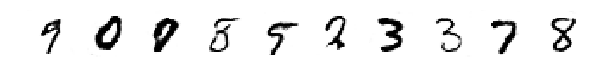

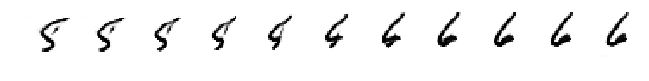

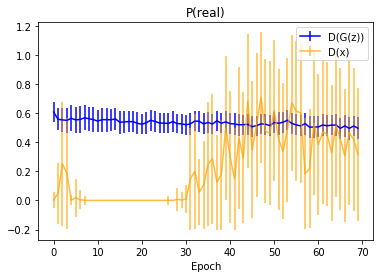

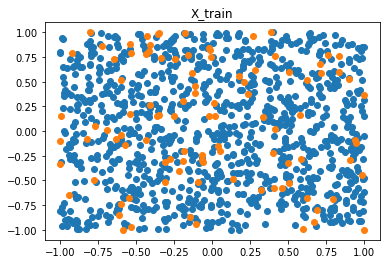

Reconstruction X_train


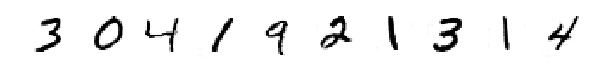

Original X_train


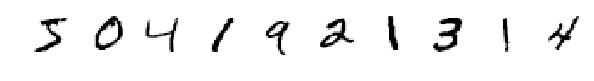

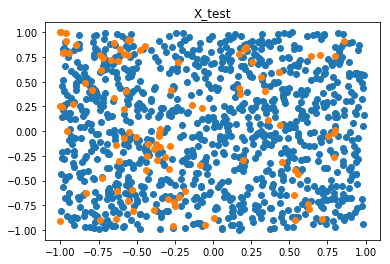

Reconstruction X_test


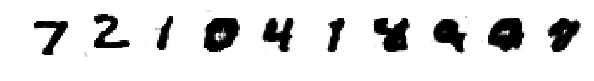

Original X_test


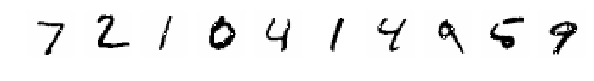


70 [D loss: 0.666337, acc.: 57.03%] [G loss: 0.884498]

71 [D loss: 0.610457, acc.: 67.58%] [G loss: 0.843088]

72 [D loss: 0.601116, acc.: 68.75%] [G loss: 0.995791]

73 [D loss: 0.662190, acc.: 58.98%] [G loss: 0.928511]

74 [D loss: 0.627007, acc.: 64.06%] [G loss: 0.976817]

75 [D loss: 0.654640, acc.: 64.45%] [G loss: 1.011668]

76 [D loss: 0.630161, acc.: 65.23%] [G loss: 0.810724]

77 [D loss: 0.663654, acc.: 60.55%] [G loss: 0.971233]

78 [D loss: 0.661021, acc.: 58.59%] [G loss: 1.046324]

79 [D loss: 0.659205, acc.: 57.81%] [G loss: 0.981218]


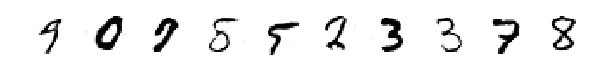

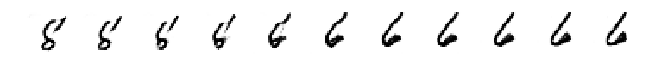

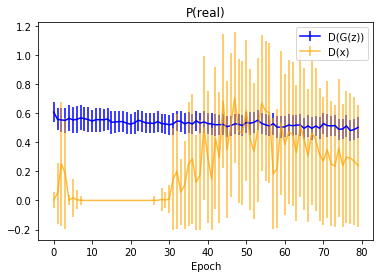

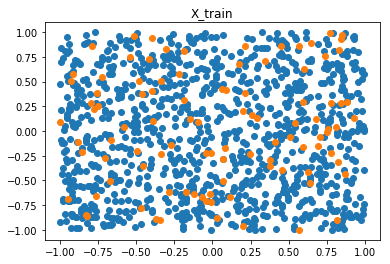

Reconstruction X_train


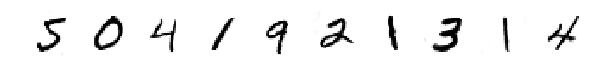

Original X_train


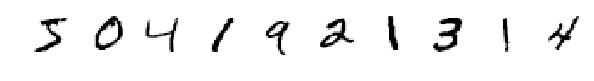

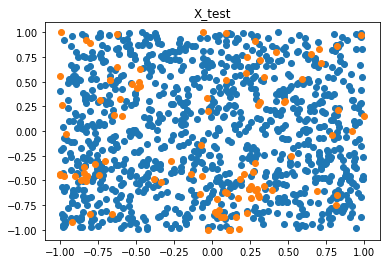

Reconstruction X_test


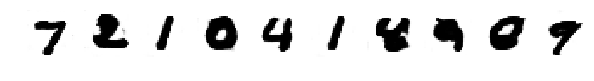

Original X_test


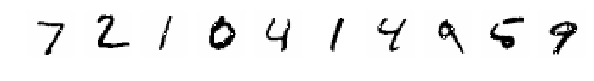


80 [D loss: 0.681596, acc.: 55.86%] [G loss: 0.951623]

81 [D loss: 0.616500, acc.: 65.23%] [G loss: 0.878603]

82 [D loss: 0.625396, acc.: 67.58%] [G loss: 1.012928]

83 [D loss: 0.567329, acc.: 73.05%] [G loss: 0.953116]

84 [D loss: 0.706209, acc.: 54.69%] [G loss: 0.961442]

85 [D loss: 0.673897, acc.: 61.33%] [G loss: 0.893166]

86 [D loss: 0.650105, acc.: 64.06%] [G loss: 0.859602]

87 [D loss: 0.617320, acc.: 67.19%] [G loss: 0.872571]

88 [D loss: 0.604501, acc.: 66.80%] [G loss: 0.987920]

89 [D loss: 0.595257, acc.: 69.14%] [G loss: 1.074607]


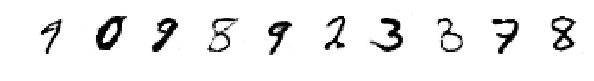

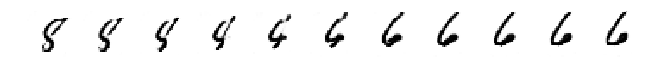

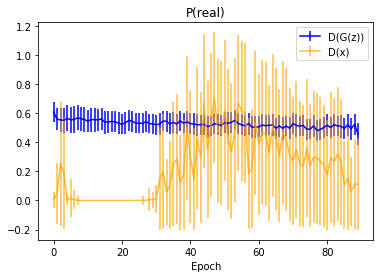

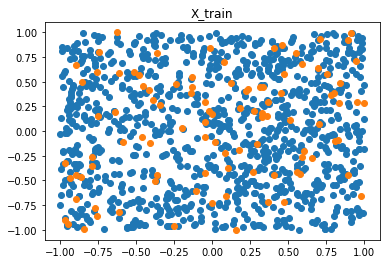

Reconstruction X_train


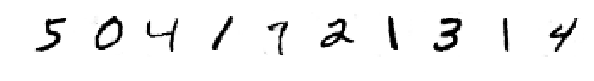

Original X_train


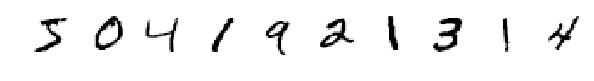

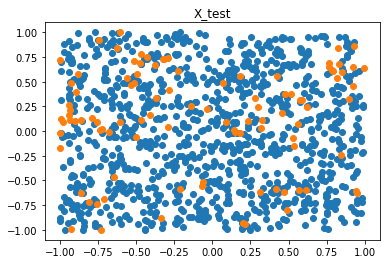

Reconstruction X_test


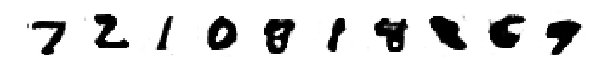

Original X_test


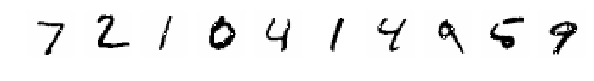


90 [D loss: 0.548293, acc.: 73.83%] [G loss: 1.071449]

91 [D loss: 0.704037, acc.: 53.12%] [G loss: 0.869307]

92 [D loss: 0.710908, acc.: 51.95%] [G loss: 1.086231]

93 [D loss: 0.622975, acc.: 66.02%] [G loss: 0.924463]

94 [D loss: 0.681877, acc.: 53.91%] [G loss: 0.823413]

95 [D loss: 0.630928, acc.: 64.45%] [G loss: 1.100244]

96 [D loss: 0.593628, acc.: 72.66%] [G loss: 1.024070]

97 [D loss: 0.676587, acc.: 56.25%] [G loss: 0.968782]

98 [D loss: 0.721501, acc.: 52.34%] [G loss: 1.054098]

99 [D loss: 0.607556, acc.: 67.97%] [G loss: 0.905551]


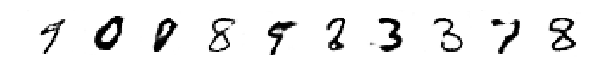

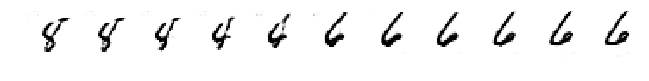

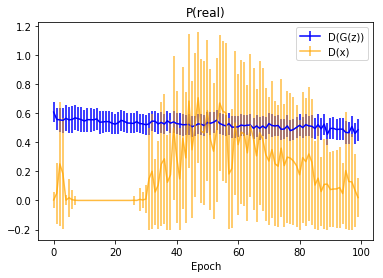

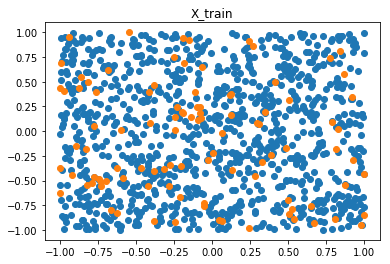

Reconstruction X_train


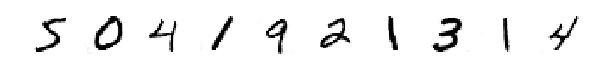

Original X_train


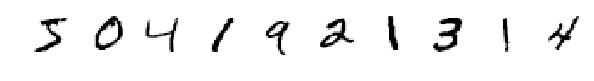

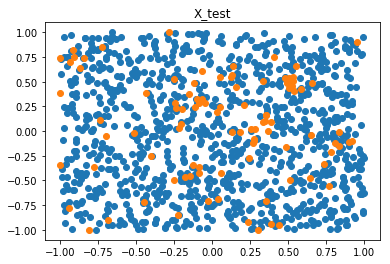

Reconstruction X_test


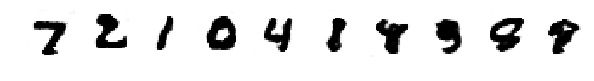

Original X_test


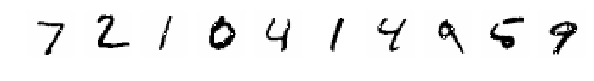

In [6]:
if regular_training:
    dcgan = gan.DCGAN(gan.Uniform(100))



    pmetric = callbacks.PMetrics(dcgan, X_test[:1000])
    period = 10
    train_callbacks = [
        (callbacks.EvolvingImageCallback(dcgan).plot, period),
        (callbacks.InterpolationCallback(dcgan).plot, period),
        (pmetric.track, 1),
        (pmetric.plot, period),
        (lambda: dcgan.save('models_mnist'), period),
        (callbacks.InverseDistributionCallback(dcgan, X_train[:100], "X_train").plot, period),
        (callbacks.InverseDistributionCallback(dcgan, X_test[:100], "X_test").plot, period)
    ]

    dcgan.train(X_train, epochs=100, batch_size=128, callbacks=train_callbacks)

# Unconnected Support Prior


0 [D loss: 0.738804, acc.: 51.95%] [G loss: 0.946527]

1 [D loss: 0.729967, acc.: 52.73%] [G loss: 0.898263]

2 [D loss: 0.687838, acc.: 58.59%] [G loss: 0.931312]

3 [D loss: 0.689437, acc.: 57.42%] [G loss: 0.848813]

4 [D loss: 0.698736, acc.: 58.98%] [G loss: 0.890727]

5 [D loss: 0.719656, acc.: 53.52%] [G loss: 0.842418]

6 [D loss: 0.695353, acc.: 55.08%] [G loss: 0.927041]

7 [D loss: 0.700544, acc.: 54.69%] [G loss: 0.899072]

8 [D loss: 0.711207, acc.: 52.73%] [G loss: 0.831643]

9 [D loss: 0.686495, acc.: 57.03%] [G loss: 0.882644]


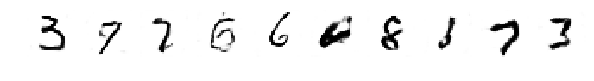

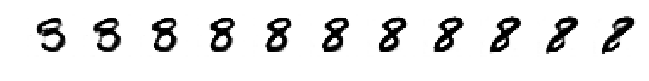

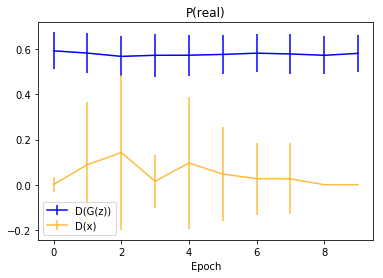

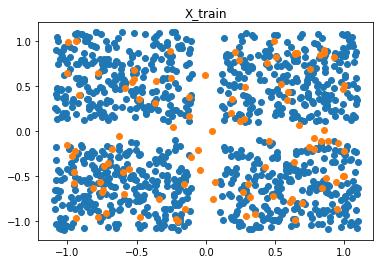

Reconstruction X_train


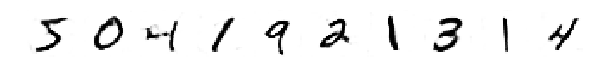

Original X_train


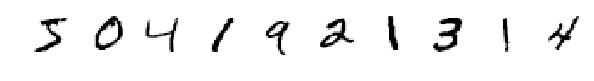

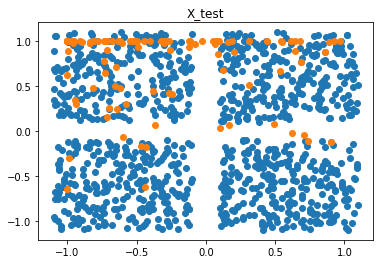

Reconstruction X_test


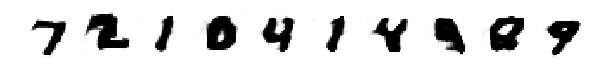

Original X_test


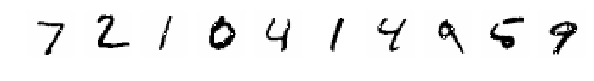


10 [D loss: 0.719942, acc.: 50.39%] [G loss: 0.864668]

11 [D loss: 0.694787, acc.: 55.08%] [G loss: 0.834402]

12 [D loss: 0.686701, acc.: 55.47%] [G loss: 0.864105]

13 [D loss: 0.684624, acc.: 54.69%] [G loss: 0.887214]

14 [D loss: 0.671117, acc.: 55.47%] [G loss: 0.873985]

15 [D loss: 0.685326, acc.: 55.08%] [G loss: 0.878637]

16 [D loss: 0.718285, acc.: 53.12%] [G loss: 0.811181]

17 [D loss: 0.697598, acc.: 54.69%] [G loss: 0.845826]

18 [D loss: 0.701404, acc.: 52.73%] [G loss: 0.817912]

19 [D loss: 0.661772, acc.: 59.38%] [G loss: 0.862093]


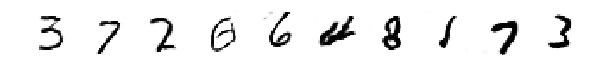

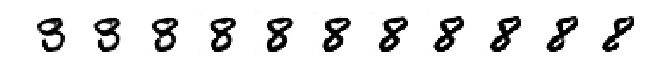

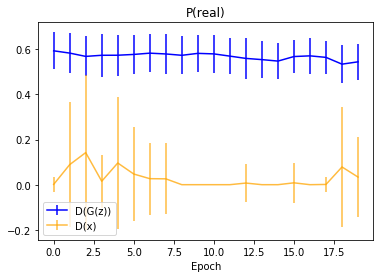

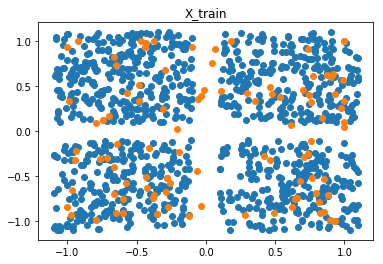

Reconstruction X_train


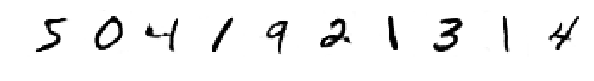

Original X_train


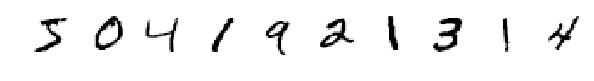

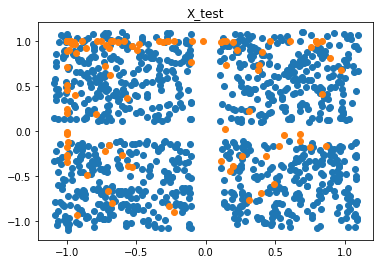

Reconstruction X_test


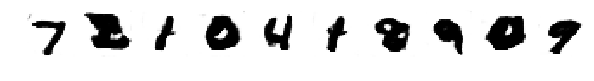

Original X_test


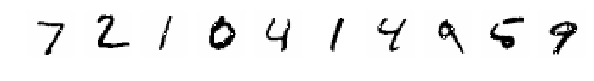


20 [D loss: 0.677866, acc.: 55.08%] [G loss: 0.819939]

21 [D loss: 0.702002, acc.: 50.00%] [G loss: 0.821033]

22 [D loss: 0.670898, acc.: 58.59%] [G loss: 0.860166]

23 [D loss: 0.693965, acc.: 57.81%] [G loss: 0.850714]

24 [D loss: 0.673118, acc.: 58.20%] [G loss: 0.850510]

25 [D loss: 0.681667, acc.: 57.42%] [G loss: 0.841375]

26 [D loss: 0.682554, acc.: 53.91%] [G loss: 0.846352]

27 [D loss: 0.665485, acc.: 58.20%] [G loss: 0.816393]

28 [D loss: 0.691726, acc.: 56.64%] [G loss: 0.830696]

29 [D loss: 0.649514, acc.: 59.38%] [G loss: 0.877408]


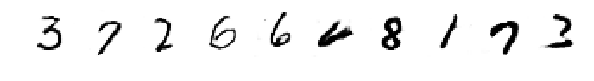

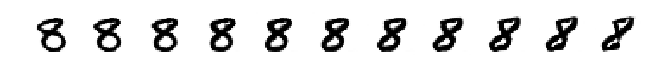

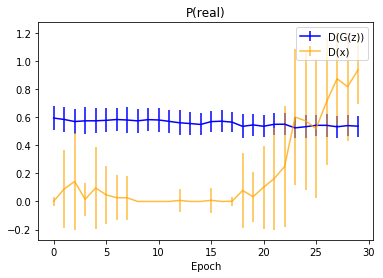

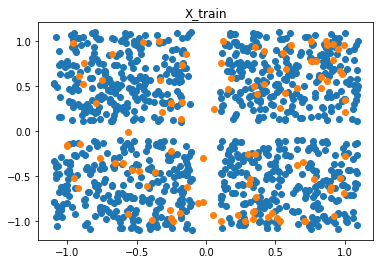

Reconstruction X_train


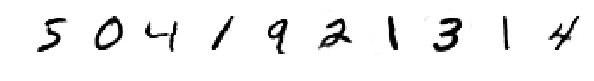

Original X_train


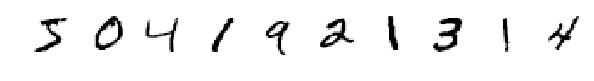

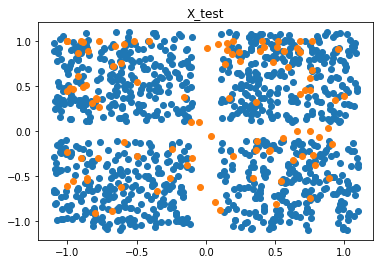

Reconstruction X_test


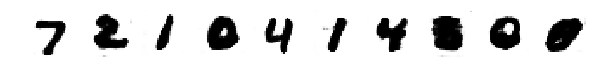

Original X_test


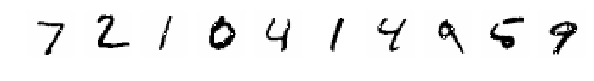


30 [D loss: 0.716447, acc.: 51.17%] [G loss: 0.847172]

31 [D loss: 0.698713, acc.: 54.30%] [G loss: 0.810214]

32 [D loss: 0.645097, acc.: 61.72%] [G loss: 0.873703]

33 [D loss: 0.675691, acc.: 54.69%] [G loss: 0.880811]

34 [D loss: 0.715826, acc.: 50.39%] [G loss: 0.825939]

35 [D loss: 0.654989, acc.: 63.67%] [G loss: 0.887386]

36 [D loss: 0.692406, acc.: 56.64%] [G loss: 0.937016]

37 [D loss: 0.686298, acc.: 61.33%] [G loss: 0.835436]

38 [D loss: 0.643767, acc.: 62.11%] [G loss: 0.881380]

39 [D loss: 0.697737, acc.: 53.52%] [G loss: 0.811439]


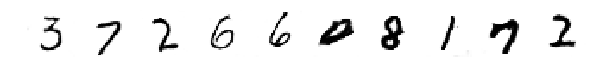

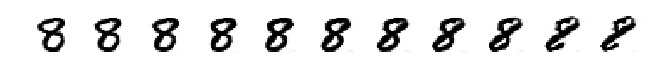

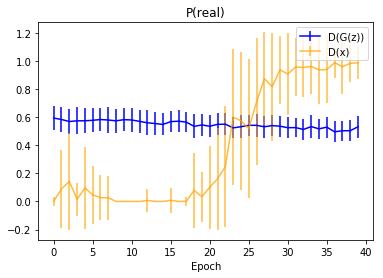

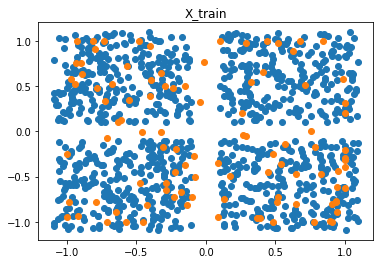

Reconstruction X_train


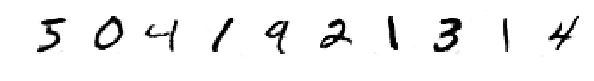

Original X_train


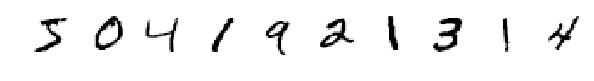

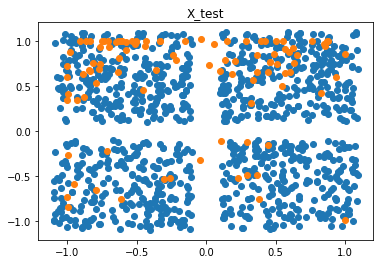

Reconstruction X_test


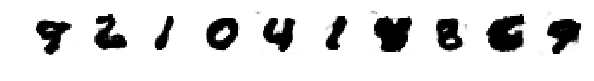

Original X_test


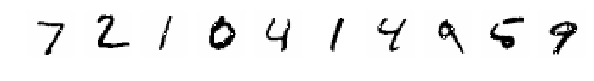


40 [D loss: 0.731487, acc.: 49.22%] [G loss: 0.889563]

41 [D loss: 0.672287, acc.: 62.89%] [G loss: 0.886960]

42 [D loss: 0.702252, acc.: 53.12%] [G loss: 0.853610]

43 [D loss: 0.690514, acc.: 54.69%] [G loss: 0.852393]

44 [D loss: 0.630473, acc.: 63.28%] [G loss: 0.872476]

45 [D loss: 0.736832, acc.: 47.66%] [G loss: 0.838240]

46 [D loss: 0.677693, acc.: 56.64%] [G loss: 0.850708]

47 [D loss: 0.678420, acc.: 56.25%] [G loss: 0.883315]

48 [D loss: 0.709958, acc.: 53.12%] [G loss: 0.978606]

49 [D loss: 0.717049, acc.: 53.91%] [G loss: 0.834616]


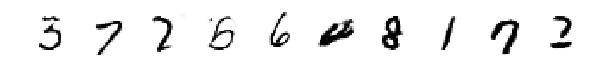

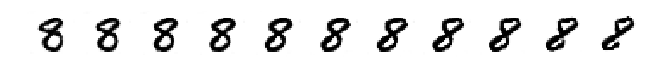

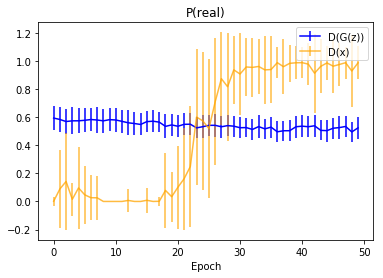

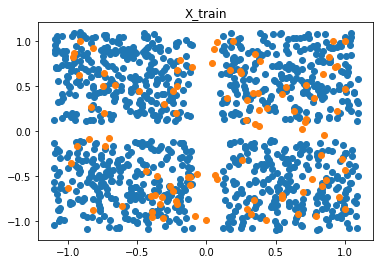

Reconstruction X_train


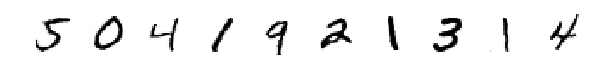

Original X_train


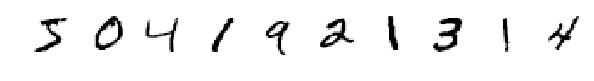

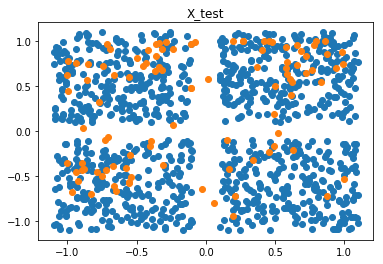

Reconstruction X_test


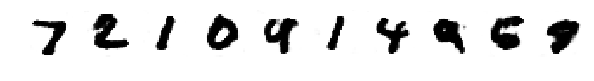

Original X_test


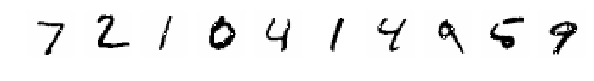


50 [D loss: 0.637419, acc.: 63.28%] [G loss: 0.908218]

51 [D loss: 0.631464, acc.: 63.67%] [G loss: 0.892325]

52 [D loss: 0.687330, acc.: 56.25%] [G loss: 1.011278]

53 [D loss: 0.588109, acc.: 72.66%] [G loss: 0.824471]

54 [D loss: 0.671264, acc.: 59.77%] [G loss: 0.914015]

55 [D loss: 0.710863, acc.: 53.12%] [G loss: 0.766033]

56 [D loss: 0.677754, acc.: 55.86%] [G loss: 0.946314]

57 [D loss: 0.607857, acc.: 66.80%] [G loss: 1.042541]

58 [D loss: 0.696181, acc.: 55.86%] [G loss: 0.814051]

59 [D loss: 0.636390, acc.: 62.11%] [G loss: 0.973142]


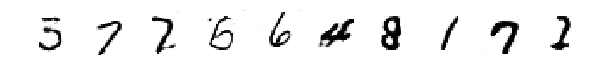

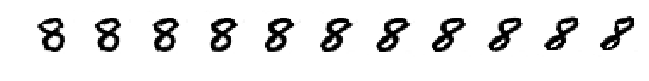

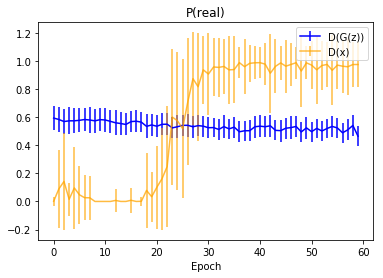

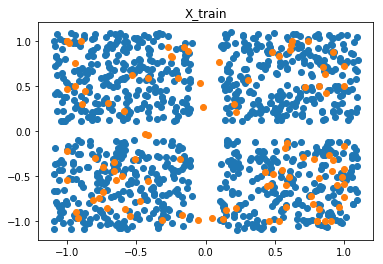

Reconstruction X_train


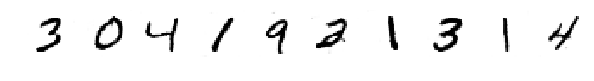

Original X_train


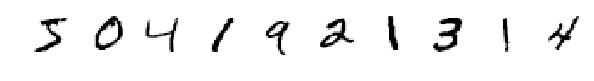

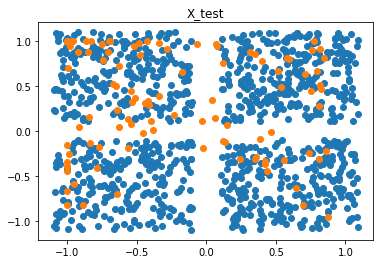

Reconstruction X_test


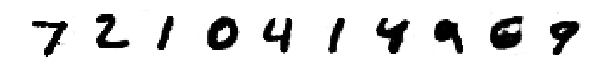

Original X_test


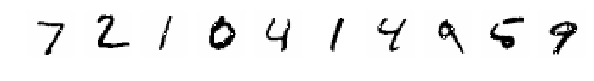


60 [D loss: 0.605834, acc.: 69.92%] [G loss: 0.805705]

61 [D loss: 0.672788, acc.: 54.30%] [G loss: 0.920086]

62 [D loss: 0.637693, acc.: 64.06%] [G loss: 0.919901]

63 [D loss: 0.653606, acc.: 60.55%] [G loss: 0.845504]

64 [D loss: 0.670983, acc.: 59.38%] [G loss: 0.890251]

65 [D loss: 0.636594, acc.: 64.45%] [G loss: 0.917515]

66 [D loss: 0.621589, acc.: 64.84%] [G loss: 0.951200]

67 [D loss: 0.652400, acc.: 63.28%] [G loss: 0.912118]

68 [D loss: 0.624901, acc.: 66.02%] [G loss: 0.905720]

69 [D loss: 0.573749, acc.: 71.88%] [G loss: 0.838061]


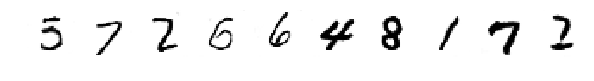

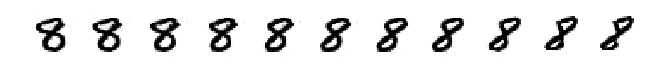

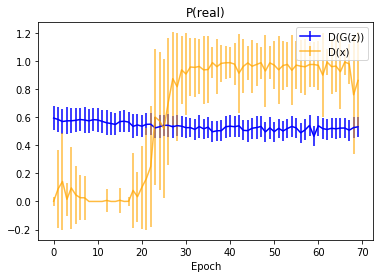

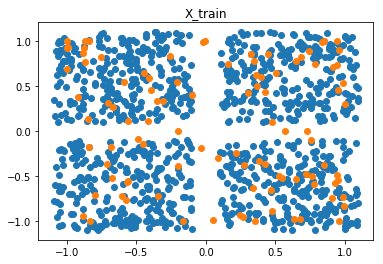

Reconstruction X_train


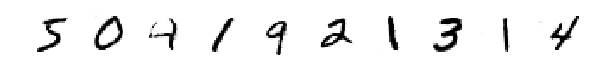

Original X_train


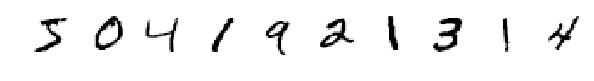

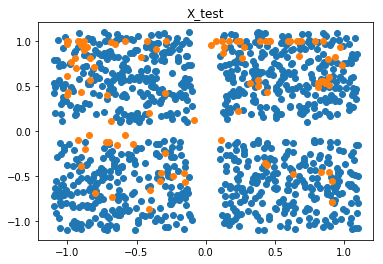

Reconstruction X_test


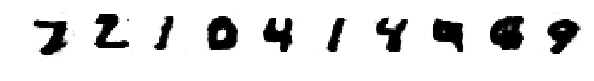

Original X_test


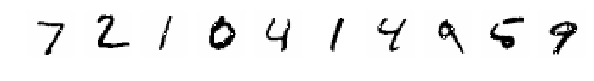


70 [D loss: 0.641256, acc.: 64.45%] [G loss: 0.828099]

71 [D loss: 0.666951, acc.: 60.55%] [G loss: 0.970013]

72 [D loss: 0.675319, acc.: 55.86%] [G loss: 0.890877]

73 [D loss: 0.765624, acc.: 45.31%] [G loss: 0.863697]

74 [D loss: 0.628393, acc.: 68.75%] [G loss: 0.840226]

75 [D loss: 0.640625, acc.: 60.94%] [G loss: 0.950205]

76 [D loss: 0.667763, acc.: 61.72%] [G loss: 0.927222]

77 [D loss: 0.693968, acc.: 58.59%] [G loss: 0.915444]

78 [D loss: 0.716554, acc.: 53.52%] [G loss: 0.735443]

79 [D loss: 0.636993, acc.: 65.23%] [G loss: 0.911203]


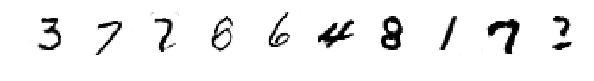

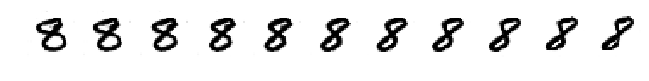

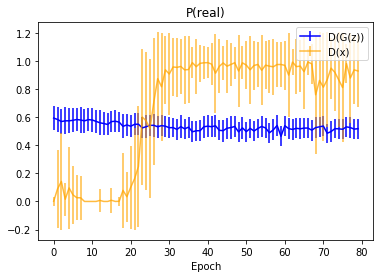

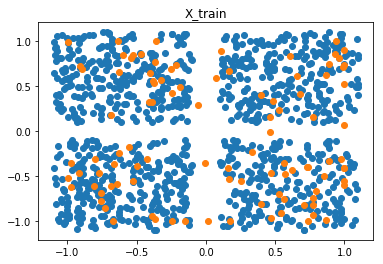

Reconstruction X_train


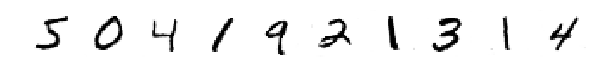

Original X_train


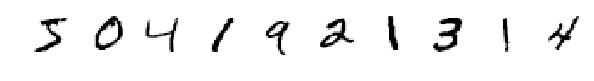

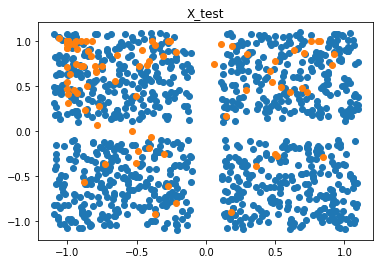

Reconstruction X_test


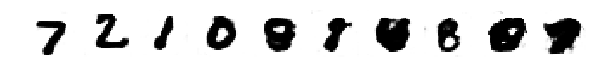

Original X_test


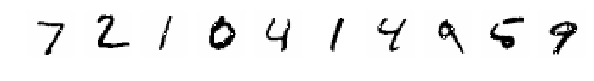


80 [D loss: 0.662564, acc.: 64.45%] [G loss: 1.061243]

81 [D loss: 0.732801, acc.: 51.17%] [G loss: 0.890822]

82 [D loss: 0.761963, acc.: 44.53%] [G loss: 0.959803]

83 [D loss: 0.686754, acc.: 55.86%] [G loss: 0.897652]

84 [D loss: 0.620129, acc.: 66.41%] [G loss: 0.952987]

85 [D loss: 0.649714, acc.: 61.72%] [G loss: 0.973887]

86 [D loss: 0.656575, acc.: 62.50%] [G loss: 0.917494]

87 [D loss: 0.664588, acc.: 60.55%] [G loss: 0.763417]

88 [D loss: 0.583279, acc.: 74.22%] [G loss: 0.964129]

89 [D loss: 0.689079, acc.: 55.08%] [G loss: 0.935846]


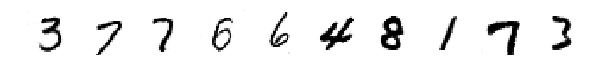

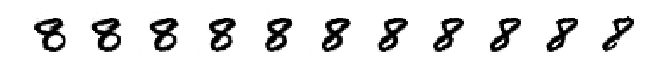

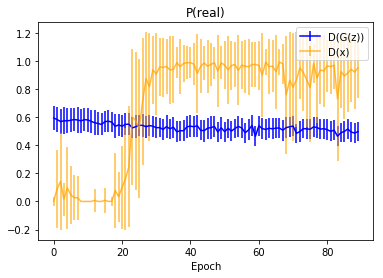

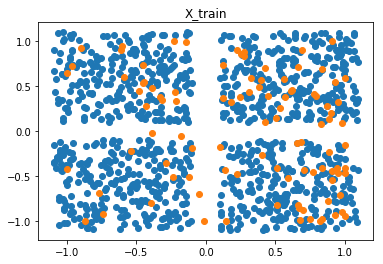

Reconstruction X_train


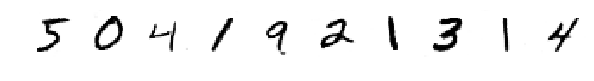

Original X_train


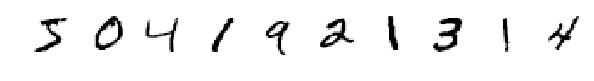

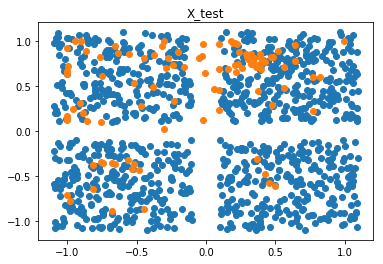

Reconstruction X_test


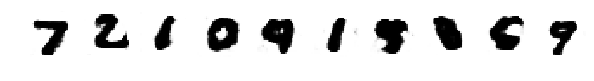

Original X_test


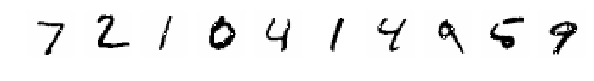


90 [D loss: 0.613208, acc.: 67.97%] [G loss: 0.862850]

91 [D loss: 0.585937, acc.: 69.92%] [G loss: 1.003469]

92 [D loss: 0.577459, acc.: 71.09%] [G loss: 1.042068]

93 [D loss: 0.778914, acc.: 43.36%] [G loss: 0.880724]

94 [D loss: 0.702056, acc.: 49.61%] [G loss: 0.987267]

95 [D loss: 0.652816, acc.: 63.28%] [G loss: 1.123259]

96 [D loss: 0.575208, acc.: 74.61%] [G loss: 1.005111]

97 [D loss: 0.615125, acc.: 64.84%] [G loss: 0.964286]

98 [D loss: 0.816106, acc.: 39.84%] [G loss: 0.803790]

99 [D loss: 0.667528, acc.: 61.33%] [G loss: 0.994805]


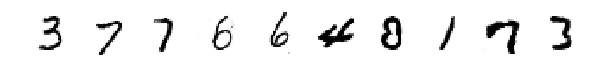

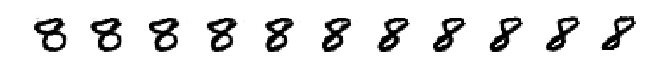

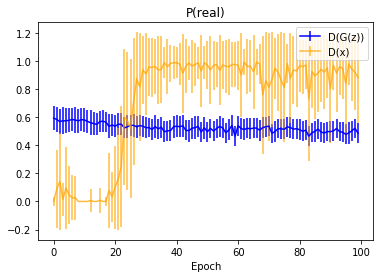

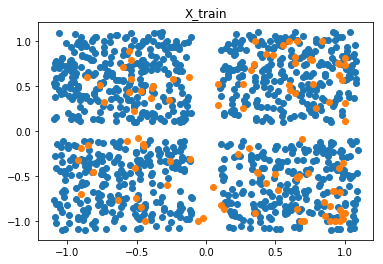

Reconstruction X_train


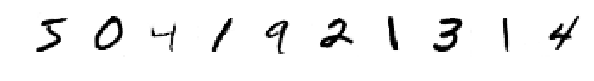

Original X_train


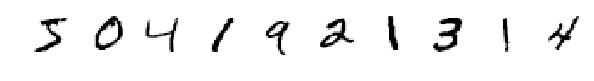

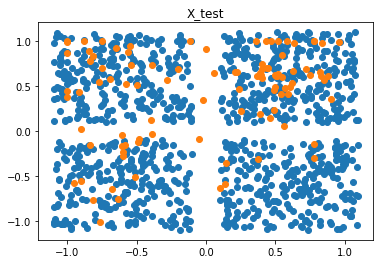

Reconstruction X_test


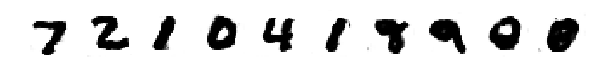

Original X_test


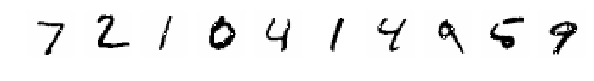

In [9]:
if unconnected_support_prior:
    dcgan = gan.DCGAN(gan.Unconnected(100))


    pmetric = callbacks.PMetrics(dcgan, X_test[:1000])
    period = 10
    train_callbacks = [
        (callbacks.EvolvingImageCallback(dcgan).plot, period),
        (callbacks.InterpolationCallback(dcgan).plot, period),
        (pmetric.track, 1),
        (pmetric.plot, period),
        (lambda: dcgan.save('models_mnist_u'), period),
        (callbacks.InverseDistributionCallback(dcgan, X_train[:100], "X_train").plot, period),
        (callbacks.InverseDistributionCallback(dcgan, X_test[:100], "X_test").plot, period)
    ]

    dcgan.train(X_train, epochs=100, batch_size=128, callbacks=train_callbacks)

# Train D more often than G

It seems that G overfits, since it can generate the samples of the train set much better than unseen images. We also observe that D's accuracy is pretty bad, so D is definitely not overfitting. We can try to train D more often, keep it close to optimum and hope that this superior discriminator will teach our G to make those digits less bold.

Instructions for updating:
Use tf.cast instead.

0 [D loss: 0.477872, acc.: 78.52%] [G loss: 1.594526]

1 [D loss: 0.341119, acc.: 87.11%] [G loss: 2.135487]

2 [D loss: 0.309044, acc.: 89.06%] [G loss: 2.658062]

3 [D loss: 0.261636, acc.: 91.02%] [G loss: 2.574317]

4 [D loss: 0.110277, acc.: 98.44%] [G loss: 3.791196]

5 [D loss: 0.242050, acc.: 91.41%] [G loss: 2.668544]

6 [D loss: 0.264941, acc.: 89.06%] [G loss: 4.224156]

7 [D loss: 0.084379, acc.: 98.05%] [G loss: 4.021694]

8 [D loss: 0.101069, acc.: 98.05%] [G loss: 2.582107]

9 [D loss: 0.020723, acc.: 99.61%] [G loss: 3.961874]


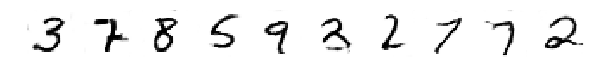

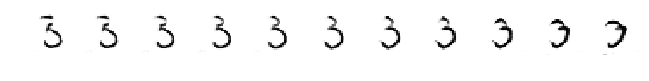

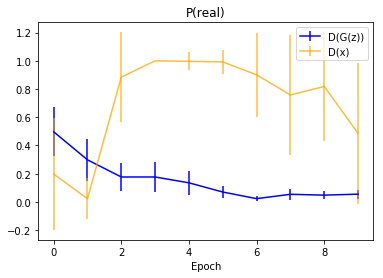

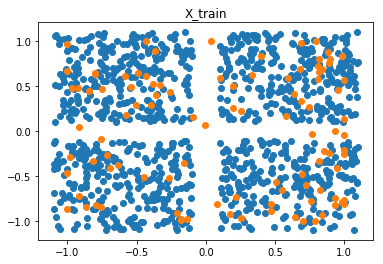

Reconstruction X_train


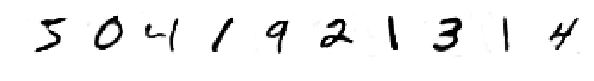

Original X_train


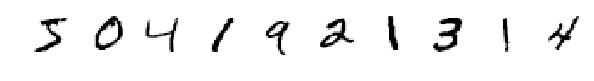

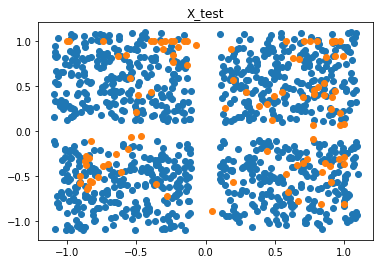

Reconstruction X_test


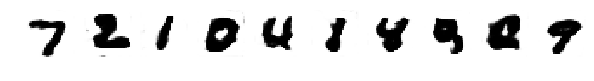

Original X_test


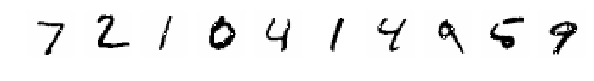


10 [D loss: 0.108738, acc.: 97.27%] [G loss: 3.712968]

11 [D loss: 0.167076, acc.: 93.75%] [G loss: 4.184496]

12 [D loss: 0.071828, acc.: 99.22%] [G loss: 5.960054]

13 [D loss: 0.131945, acc.: 97.66%] [G loss: 6.631542]

14 [D loss: 0.108831, acc.: 96.88%] [G loss: 5.227365]

15 [D loss: 0.155337, acc.: 95.70%] [G loss: 5.005673]

16 [D loss: 0.010669, acc.: 100.00%] [G loss: 3.095818]

17 [D loss: 0.093565, acc.: 98.44%] [G loss: 5.974021]

18 [D loss: 0.023473, acc.: 99.61%] [G loss: 4.566818]

19 [D loss: 0.059438, acc.: 99.22%] [G loss: 4.384412]


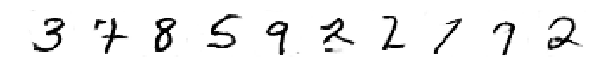

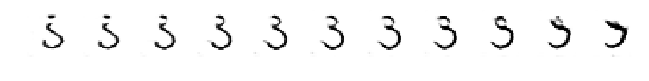

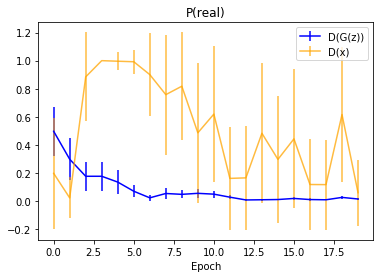

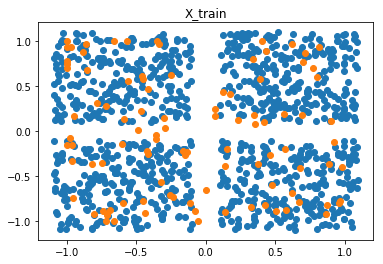

Reconstruction X_train


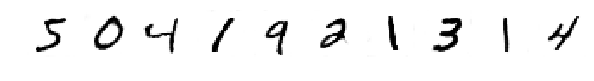

Original X_train


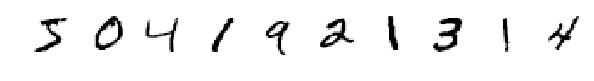

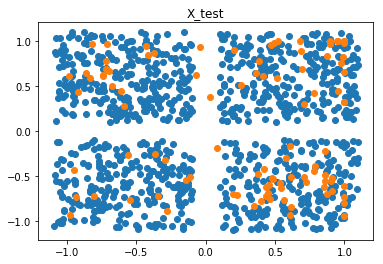

Reconstruction X_test


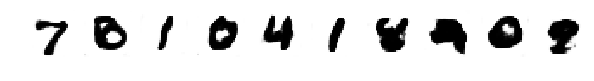

Original X_test


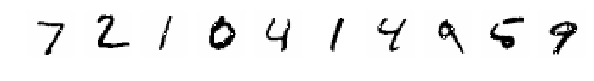


20 [D loss: 0.214790, acc.: 92.58%] [G loss: 2.747820]


KeyboardInterrupt: ignored

In [5]:
if train_d_more_often:
    dcgan = gan.DCGAN(gan.Unconnected(100))



    pmetric = callbacks.PMetrics(dcgan, X_test[:1000])
    period = 10
    train_callbacks = [
        (callbacks.EvolvingImageCallback(dcgan).plot, period),
        (callbacks.InterpolationCallback(dcgan).plot, period),
        (pmetric.track, 1),
        (pmetric.plot, period),
        (lambda: dcgan.save('models_mnist_u'), period),
        (callbacks.InverseDistributionCallback(dcgan, X_train[:100], "X_train").plot, period),
        (callbacks.InverseDistributionCallback(dcgan, X_test[:100], "X_test").plot, period)
    ]

    dcgan.train(X_train, epochs=100, batch_size=128, callbacks=train_callbacks, d_steps=5)

The assumption is wrong.

# Mode Collapse Observer Callback


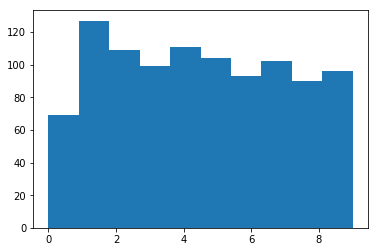

In [19]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow import keras
#Callback to classify digits and do a histogram

class ModeCollapseObserver():
    def __init__(self, gan, mode_predictor):
        self.gan = gan
        self.mode_predictor = mode_predictor
      
    def __call__(self):
        z = self.gan.prior(1000)
        img = self.gan.generator.predict(z)
        modes = self.mode_predictor.predict(img).argmax(1)
        plt.hist(modes)
        plt.show()
        
        
def train_mnist_predictor():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(X_train, Y_train,
              batch_size=128,
              epochs=12,
              verbose=1,
              validation_data=(X_test, Y_test))
    model.save(f"{PROJECT_PATH}/mnist_predictor.h5")

#train_mnist_predictor()
    
def get_mnist_predictor():
    return load_model(f"{PROJECT_PATH}/mnist_predictor.h5")
    
collapse_observer = ModeCollapseObserver(dcgan, get_mnist_predictor())()

    
      